# 05_Surface_crack_classification

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 瑕疵資料讀入及前處理
ref: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

In [3]:
data_path = "crack_datasets/"
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data.head()

,file,class
0,good/00462.jpg,good
1,good/00040.jpg,good
2,good/00752.jpg,good
3,good/00332.jpg,good
4,good/00512.jpg,good


Text(0, 0.5, '')

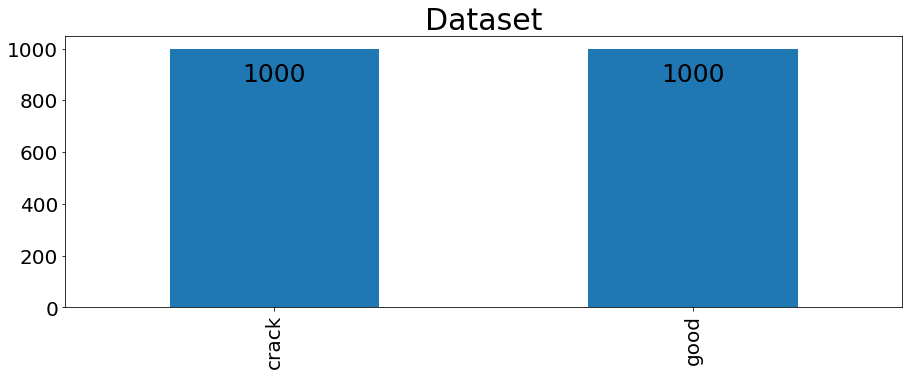

In [4]:
ax = data.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = data.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Dataset", fontsize=30)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

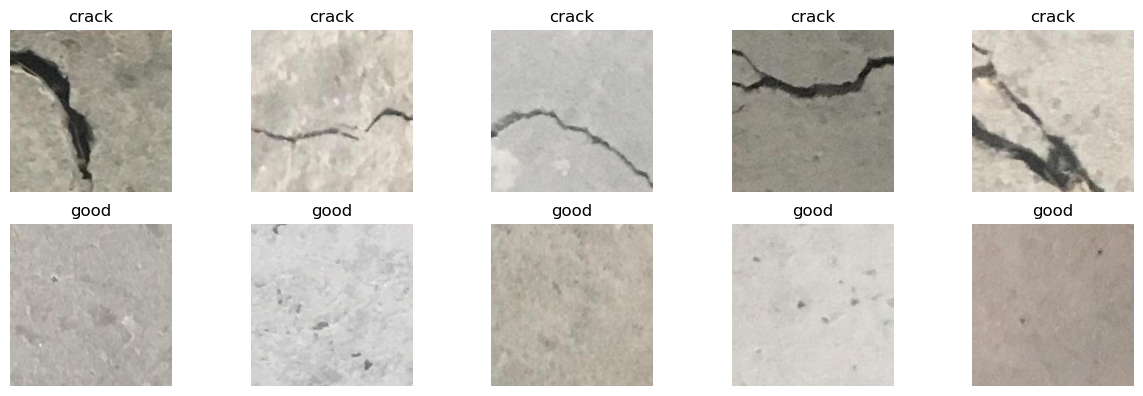

In [5]:
fig = plt.figure(figsize=(15, 15), dpi=100)
i = 1
for label, files in data.groupby('class')['file']:
    for file in files[:5]:
        img = cv2.imread(os.path.join(data_path, file), cv2.IMREAD_COLOR)[:, :, ::-1]
        plt.subplot(6, 5, i)
        plt.title(label)
        plt.imshow(img)
        plt.axis('off')
        i+=1
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(data,
                                        test_size=0.1,
                                        random_state=2022,
                                        stratify=data['class'].values)

Text(0, 0.5, '')

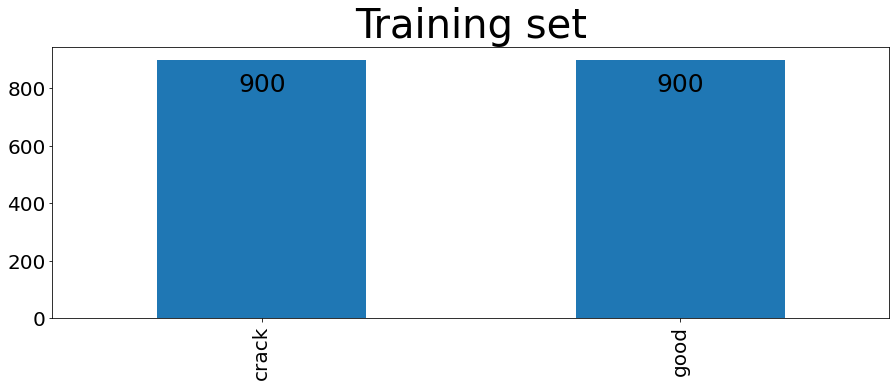

In [7]:
ax = train_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = train_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Training set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

Text(0, 0.5, '')

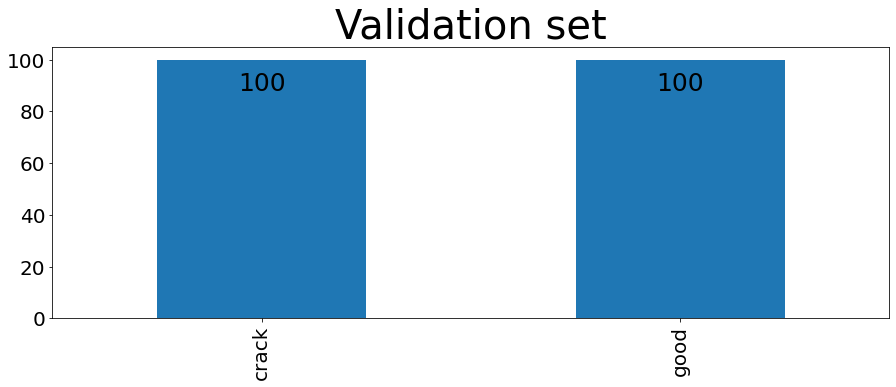

In [8]:
ax = val_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = val_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Validation set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

## 讀入 Pre-trained Model

In [9]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [10]:
img_size = 224
num_class = len(data['class'].unique())

In [11]:
model_name = 'ResNet50'
base_model = ResNet50(weights='imagenet', include_top=False,
                   input_shape=(img_size, img_size, 3))
x = GlobalAveragePooling2D()(base_model.output)
outputs = Dense(num_class, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# 決定 Pre-Train 參數量

In [12]:
base_model.trainable = True

# trainable_layer = 10
# for layer in base_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

# Data Augmentation

In [13]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 10

In [14]:
train_datagen = ImageDataGenerator(
                                   brightness_range=(0.8, 1.2),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=360,
                                   fill_mode='constant',
                                   cval = 255,
                                   preprocessing_function=preprocess_input
                                  )
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="file",
                                                    y_col="class",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = datagen.flow_from_dataframe(dataframe=val_list,
                                            directory=data_path,
                                            x_col="file",
                                            y_col="class",
                                            target_size=img_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 1800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


## 開始訓練模型

In [16]:
def callbacks_fun(model_name, img_size):
    model_dir = f'model-logs/{model_name}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    logfiles = model_dir + '/basic_model'
    modelfiles = model_dir + f'/{model_name}_{img_size}.h5'
    model_cbk = TensorBoard(log_dir=logfiles, histogram_freq=1)
    model_mckp = ModelCheckpoint(modelfiles,
                                 monitor='val_accuracy',
                                 save_best_only=True)  
    LR_decay = ReduceLROnPlateau(monitor='val_loss',
                                 patience=3,
                                 verbose=1,
                                 factor=0.8)

    return [model_cbk, model_mckp, LR_decay]

In [17]:
# 設定 cllbacks
callbacks_list = callbacks_fun(model_name, img_size)

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=num_steps,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/10
 1/57 [..............................] - ETA: 0s - loss: 0.6272 - accuracy: 0.7188WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
57/57 [==============================] - 22s 391ms/step - loss: 0.1760 - accuracy: 0.9572 - val_loss: 224.5002 - val_accuracy: 0.6650
Epoch 2/10
57/57 [==============================] - 21s 361ms/step - loss: 0.0698 - accuracy: 0.9750 - val_loss: 0.3678 - val_accuracy: 0.9500
Epoch 3/10
57/57 [==============================] - 19s 336ms/step - loss: 0.0265 - accuracy: 0.9883 - val_loss: 0.7236 - val_accuracy: 0.7350
Epoch 4/10
57/57 [==============================] - 19s 337ms/step - loss: 0.0187 - accuracy: 0.9950 - val_loss: 0.3108 - val_accuracy: 0.9450
Epoch 5/10
57/57 [==============================] - 19s 338ms/step

## 訓練結果視覺化

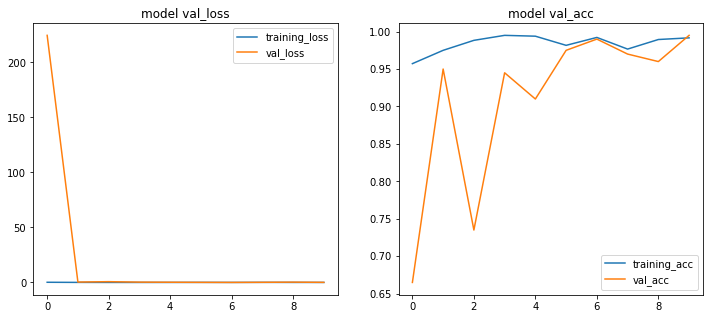

In [19]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [20]:
model = load_model(f'./model-logs/{model_name}/{model_name}_{img_size}.h5')

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
y_pred = model.predict(val_generator).argmax(-1)
y_val = val_generator.classes

In [22]:
val_generator.class_indices.keys()

dict_keys(['crack', 'good'])

ResNet50 Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



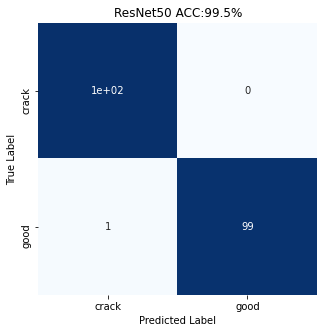

In [23]:
print(f"{model_name} Report: \n", classification_report(y_val, y_pred))
ACC = accuracy_score(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
                          xticklabels=val_generator.class_indices.keys(),
                          yticklabels=val_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'{model_name} ACC:{ACC*100:.4}%')
plt.show()

## 顯示預測錯誤的影像

In [24]:
err_idx = np.where(y_val!=y_pred)[0]
n = len(err_idx)

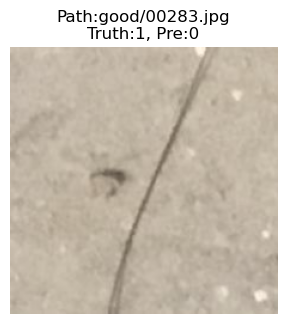

In [25]:
# show image
fig = plt.figure(figsize=(20, 10), dpi=100)
for i, idx in enumerate(err_idx):
    img = cv2.imread(os.path.join(data_path, val_list['file'].values[idx]), cv2.IMREAD_COLOR)[:, :, ::-1]
    img = cv2.resize(img, (img_size, img_size))
    plt.subplot(math.ceil(n/5), 5, i+1)
    plt.title('Path:'+val_list['file'].values[idx]+'\nTruth:'+str(y_val[idx])+', Pre:'+str(y_pred[idx]))
    plt.imshow(img)
    plt.axis('off')
plt.show()

## [1. Grad-CAM (Ancona et al. 16)](https://arxiv.org/abs/1610.02391)

In [26]:
import matplotlib.cm as cm

In [27]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [28]:
def infer_target_layer(model):

    for layer in reversed(model.layers):
        # Select closest 4D layer to the end of the network.
        if len(layer.output_shape) == 4:
            return layer.name

    raise ValueError(
        "Model does not seem to contain 4D layer. CAM-Based method cannot be applied."
    )

In [29]:
def gradcam(image,
            model,
            layer_name=None,
         target_class_idx=None):
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    if layer_name is None:
        layer_name = infer_target_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(inputs)
        if target_class_idx is None:
            target_class_idx = tf.argmax(preds[0])
        class_channel = preds[:, target_class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap

In [30]:
def display_gradcam(image, heatmap, method='Grad CAM'):
    heatmap_3dim = tf.expand_dims(heatmap, axis=2)
    attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                            subplot_kw={'xticks':[], 'yticks':[]})

    axs[0, 0].set_title('Original image', fontsize=20)
    axs[0, 0].imshow(image/255)

    axs[0, 1].set_title(method, fontsize=20)
    axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[0, 2].set_title('Overlay', fontsize=20)
    axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[0, 2].imshow(image/255, alpha=0.4)

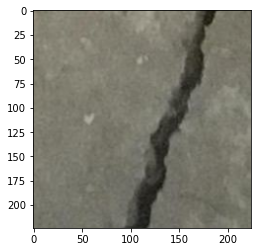

In [31]:
image = read_image('crack_datasets/crack/00333.jpg')
plt.imshow(image/255)

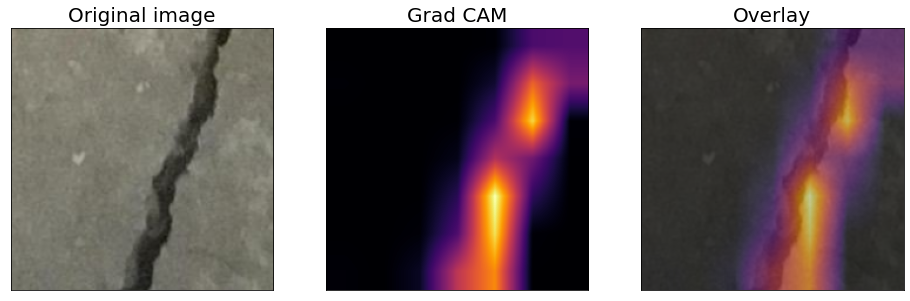

In [32]:
heatmap = gradcam(image, model)
display_gradcam(image, heatmap)

## [2. Layer-CAM (Peng-Tao et al. 21)](http://mftp.mmcheng.net/Papers/21TIP_LayerCAM.pdf)

In [33]:
def layercam(image,
             model,
             layer_names,
             target_class_idx):
    # Generate class activation heatmap
    heatmaps = []
    for layer_name in layer_names:
        heatmap = gradcam(image, model, layer_name, target_class_idx)
        heatmaps.append(heatmap)
    
    hm_out = np.zeros((28, 28))
    for hm in heatmaps:
        hm_out += cv2.resize(hm.numpy(), (28, 28))
    hm_out /= tf.math.reduce_max(hm_out)
    return hm_out, heatmaps

In [34]:
layer_names = ['conv5_block3_out', 'conv4_block6_out', 'conv3_block4_out']
heatmap, heatmaps = layercam(image, model, layer_names, 0)
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

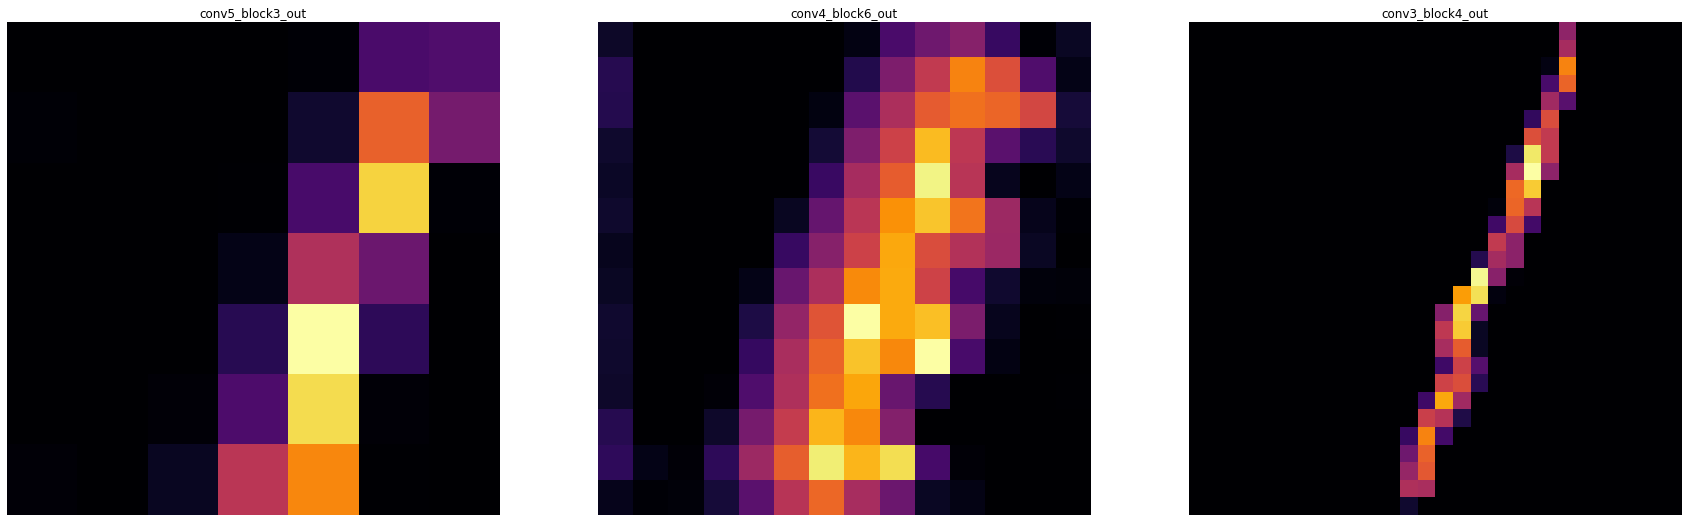

In [35]:
_, axes = plt.subplots(1, len(heatmaps), figsize=(30, 10))
for idx, name, hm in zip(range(len(heatmaps)), layer_names, heatmaps):
    axes[idx].imshow(hm, cmap=cm.inferno); 
    axes[idx].axis('off');
    axes[idx].set_title(name);
plt.show()

In [36]:
hm_out = np.zeros((28, 28))
for hm in heatmaps:
    hm_out += cv2.resize(hm.numpy(), (28, 28))
hm_out /= tf.math.reduce_max(hm_out)

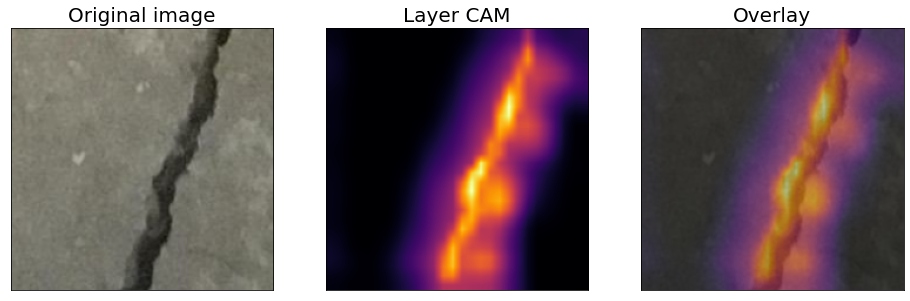

In [37]:
display_gradcam(image, hm_out, 'Layer CAM')

### 練習時間：
#### 試試看用不同資料集來訓練一個模型並用 CAM-based 的方法解釋他們
該資料是東北大學的幾位老師收集的，資料中包含了 6 種缺陷，每種缺陷 300 張，影像尺寸為 200x200：

<img src="slide_image/NEU-surface-defect-database.jpg" width=720/>

- 裂紋 (Crazing)
- 夾雜 (Inclusion)
- 斑塊 (Patches)
- 麻點 (Pitted surface)
- 壓入氧化皮 (Rolled-in scale)
- 劃痕 (Scratches)：

資料連結：https://drive.google.com/file/d/1YSePHsKINhHRbbR5PWoOHldiiROgdla_/view?usp=sharing

